In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [165]:
DICT_LINK_INDEX = {'Admin':1,'Banking':1,'Education':1,'Manufacture':1}
DICT_COMPANY_INDEX = {'Admin':2,'Banking':2,'Education':2,'Manufacture':2}
DICT_AREA_INDEX = {'Admin':3,'Banking':3,'Education':3,'Manufacture':3}
DICT_DATE_INDEX = {'Admin':4,'Banking':5,'Education':5,'Manufacture':5}
DICT_CLASSFICATION_INDEX = {'Admin':5,'Banking':6,'Education':6,'Manufacture':6}
DICT_SALARY_FLOOR = {'Admin':35000,'Banking':53000,'Education':48000,'Manufacture':24600}
DICT_SALARY_CEILING = {'Admin':55000,'Banking':85000,'Education':79000,'Manufacture':116000}
ANNUAL_WORKING_HOUR = 8*200

In [166]:
def pre_cleaning(df,i,j,k):
    df['company_name']=df[i]
    df[['posted_time','featured_at']]=df[j].str.split(',',expand=True)[[0,2]]
    df.loc[df['company_name'].isna(),'company_name']= df['featured_at']
    df['ad_type']= df[k].str.extract('\=(\w+)\#')
    return df

In [167]:
def listing_time_cleaning(df):
    df['listing_time_indays'] = df['posted_time'].str.extract('(\d+[a-z])')
    df['listing_time_indays'] = df['listing_time_indays'].str.extract('(\w+)d')
    df['listing_time_indays'].fillna('0', inplace = True)
    df['listing_time_indays'] #notice that if the ad_type is promoted, the listing time is recorded as "Featured", which means the listing times of those featured advs may be longer.
    return df

In [168]:
#useful function
def deduplication(x):
    mid = len(x)//2
    if x != 'unknown':
        return x[:mid+1]
    else:
        return 'unknown'
def smart_deduplication(x):
    trim = x.strip()
    index = (trim+trim).find(trim,1)
    if index != -1:
        return trim[:index]
    else:
        return 'unknown'

In [169]:
def location_cleaning(df,i):
    df[['location','area']] = df[i].str.split("area:",expand= True)
    df['location'] = df['location'].apply(lambda x:x[9:])
    df['location'] = df['location'].apply(smart_deduplication)
    df['area'].fillna('unknown', inplace = True)
    df['area'] = df['area'].apply(smart_deduplication)
    return df

In [170]:
def classification_cleaning(df,i):
    df[['subclassification','Classification']] = df[i].str.split('subClassification:',expand=True)
    df['subclassification'] = df['subclassification'].apply(lambda x:x[15:])
    df['Classification'].fillna('unknown', inplace = True)
    df['Classification'] = df['Classification'].apply(smart_deduplication)
    df[['mainClassification','7','subclassification']] = df['subclassification'].str.split('&',expand=True)
    df['subclassification'].fillna('unknown', inplace = True)
    return df

In [171]:
def random_salary(df,i,salary_floor,salary_ceiling):    
    df['salary']=df[i]
    df[df['salary'].str.contains('\d',na=False)]['salary']
    df['salary']= df[df['salary'].str.contains('\d',na=False)]['salary'].str.replace(' to ','-',regex=True)
    df['salary']= df[df['salary'].str.contains('\d',na=False)]['salary'].str.replace('\d\%','',regex=True)
    df['salary']= df[df['salary'].str.contains('\d',na=False)]['salary'].str.replace(',','',regex=True)
    df['salary']= df[df['salary'].str.contains('\d',na=False)]['salary'].str.replace(' ','',regex=True)
    df['salary'].fillna('unknown', inplace=True)
    df[['low_salary','high_salary']] = df['salary'].str.split('-', n=1,expand=True).fillna('unknown')
    df['low_salary'] = df['low_salary'].str.extract('(\d+\.\d+|\d+ \d+|\d+k|\d+)')
    df['high_salary'] = df['high_salary'].str.extract('(\d+\.\d+|\d+ \d+|\d+k|\d+)')
    df['low_salary'] = df[df['low_salary'].str.contains('\d',na=False)]['low_salary'].str.replace('k', '000',regex=True)
    df['high_salary'] = df[df['high_salary'].str.contains('\d',na=False)]['high_salary'].str.replace('k', '000',regex=True)
    df['low_salary'] = df['low_salary'].fillna('unknown')
    df['high_salary'] = df['high_salary'].fillna('unknown')
    df.loc[df['low_salary'] == 'unknown', 'low_salary'] = df['high_salary']
    df.loc[df['high_salary'] == 'unknown', 'high_salary'] = df['low_salary']

    for r, row in enumerate(df['low_salary'].values):
        if row == 'unknown':
            df['low_salary'][r] = np.random.randint(salary_floor, salary_ceiling, size=1)[0]

    for r, row in enumerate(df['high_salary'].values):
        if row == 'unknown':
            df['high_salary'][r] = max(np.random.randint(salary_floor, salary_ceiling, size=1)[0], df['low_salary'][r])
    df['low_salary'] = df['low_salary'].astype('float32')
    df['high_salary'] = df['high_salary'].astype('float32')
    df.loc[df['low_salary'] < 50, 'low_salary'] =df['low_salary'] * ANNUAL_WORKING_HOUR
    df.loc[df['high_salary'] < 50, 'high_salary'] =df['high_salary'] * ANNUAL_WORKING_HOUR
    
    #threshold = (45000+75000) /2
    #df['lower_salary'] = np.random.randint(45000, threshold, df.shape[0])
    #df['upper_salary'] = np.random.randint(threshold, 75000, df.shape[0])

    return df



In [172]:
def clean_jobs(file_name,job):
    df = pd.read_excel(file_name,engine="openpyxl",header = None)
    clean_job = (df.pipe(pre_cleaning,DICT_COMPANY_INDEX[job],DICT_DATE_INDEX[job],DICT_LINK_INDEX[job]).
        pipe(listing_time_cleaning).
        pipe(location_cleaning,DICT_AREA_INDEX[job]).
        pipe(classification_cleaning,DICT_CLASSFICATION_INDEX[job]).
        pipe(random_salary,DICT_CLASSFICATION_INDEX[job],DICT_SALARY_FLOOR[job],DICT_SALARY_CEILING[job])#salary floor and ceiling
    )
    return df

In [173]:

df = clean_jobs("NZ_Admin_JOBS.xlsx",'Admin') #input the file name
df[['company_name', 'posted_time','ad_type','listing_time_indays','location','area','Classification','low_salary','high_salary']]


,company_name,posted_time,ad_type,listing_time_indays,location,area,Classification,low_salary,high_salary
0,Private Advertiser,Featured,promoted,0,Bay of Plenty,Tauranga,Office Management,48728.0,48728.0
1,Avenues Orthodontics,Featured,promoted,0,Bay of Plenty,Tauranga,Receptionists,45856.0,51100.0
2,New Zealand Police,4d ago,standard,4,Auckland,unknown,Other,52446.0,52446.0
3,Kew Pacific Island Early Learning Centre,1h ago,standard,0,Southland,Invercargill,Administrative Assistants,52230.0,52480.0
4,Private Advertiser,4d ago,standout,4,Canterbury,Christchurch,Client & Sales Administration,39828.0,51588.0
...,...,...,...,...,...,...,...,...,...
2703,Hays Talent Solutions,27d ago,standout,27,Auckland,Auckland Central,Client & Sales Administration,39438.0,52045.0
2704,one eighty recruitment,27d ago,standout,27,Wellington,"Wellington CentralWellington Central,Competiti...",unknown,54742.0,54742.0
2705,Asset Recruitment Ltd,20d ago,standout,20,Waikato,"HamiltonHamilton,Competitive hourly rates $$",unknown,42631.0,50192.0
2706,Asset Recruitment Ltd,28d ago,standout,28,Waikato,"HamiltonHamilton,Competitive hourly rates $$",unknown,49080.0,53968.0


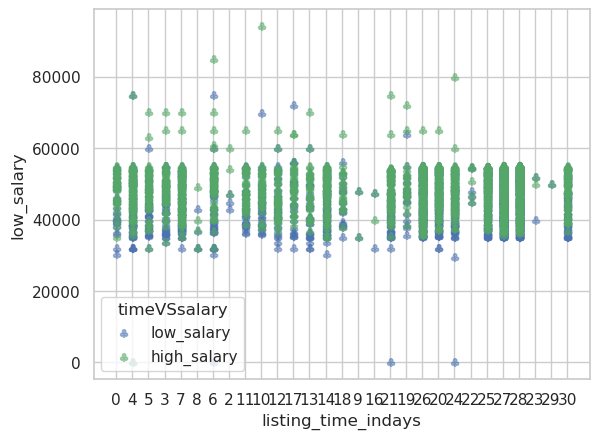

In [174]:

# Fixing random state for reproducibility
np.random.seed(20210326)


x = df['listing_time_indays']
y = df['low_salary']
y1 = df['high_salary']
plt.scatter(x, y, c="b", alpha=0.5, marker=r'$\clubsuit$',
            label="timeVSsalary")
plt.scatter(x, y1, c="g", alpha=0.5, marker=r'$\clubsuit$')
plt.xlabel("listing_time_indays")
plt.ylabel("low_salary")
plt.legend(['low_salary','high_salary'],
                    loc="lower left", title="timeVSsalary")
plt.show()


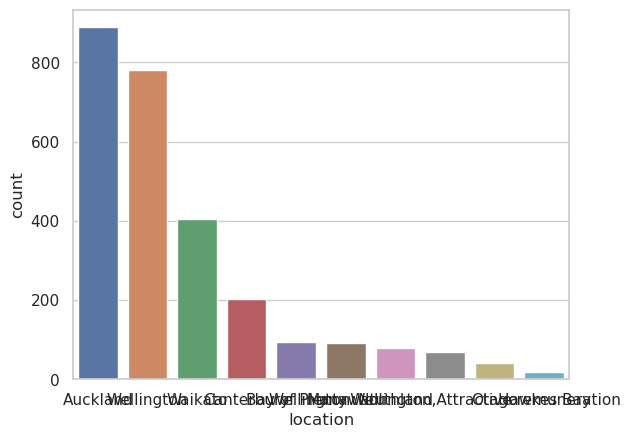

In [175]:
df['count'] = 1
jobplot = df[['location','count']].groupby(['location']).sum().reset_index()
jobplot = jobplot.sort_values(by=['count'],ascending=False).head(10)
ax =sns.barplot(x="location", y="count", data=jobplot)


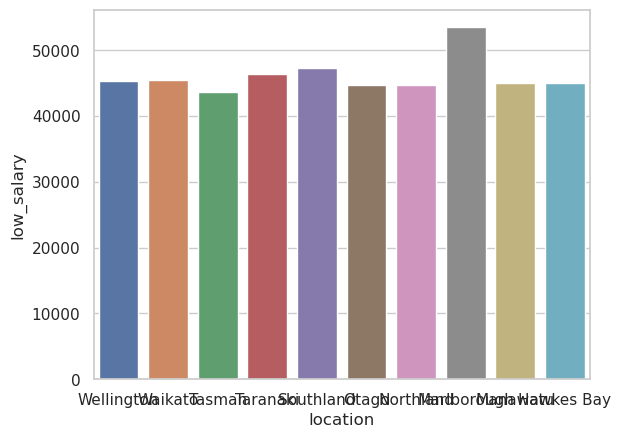

In [179]:
area_salary = df[['location','low_salary','high_salary']].groupby(['location']).mean().reset_index()
area_salary = area_salary.sort_values(by=['location'],ascending=False).head(16)
area_salary.drop(area_salary.head(6).index, inplace=True)
area_salary

ax = sns.barplot(x="location", y="low_salary", data=area_salary)